# The Principal Components of Anthropometry

In a previous post I explored the correlations between measurements in the ANSUR-II dataset, which includes 93 measurements from a sample of U.S. military personnel.
I found that measurements of the head were weakly correlated with measurements from other parts of the body -- and in particular the protrusion of the ears is almost entirely uncorrelated with anything else.

A friend of mine, and co-developer of the [Modeling and Simulation](https://greenteapress.com/wp/modsimpy/) class I taught at Olin, asked whether I had tried running principal component analysis (PCA).
I had not, but now I have. Let's look at the results.

This notebook is an offshoot of Chapter 1 of [*Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions*](https://probablyoverthinking.it).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt/blob/book/examples/ansur_pca.ipynb).

In [1]:
# Install empirical dist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The data

Here's the ANSUR data, originally downloaded from [The OPEN Design Lab](https://www.openlab.psu.edu/ansur2/).

In [4]:
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIFEMALEPublic.csv")
download("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/ANSURIIMALEPublic.csv")

In [5]:
ansur_female = pd.read_csv("ANSURIIFEMALEPublic.csv", encoding="ISO-8859-1")
ansur_female.shape

(1986, 108)

In [6]:
ansur_male = pd.read_csv("ANSURIIMALEPublic.csv", encoding="ISO-8859-1")
ansur_male.shape

(4082, 108)

Since heights are in mm, I converted to cm.

In [7]:
height_male = ansur_male["stature"] / 10
height_female = ansur_female["stature"] / 10

In [8]:
measurements = [column for column in ansur_female.columns if column.lower() == column]
measurements

['abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbreadth',
 'headcir

In [9]:
len(measurements)

93

In [10]:
ansur_male[measurements]

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight
0,266,1467,337,222,1347,253,202,401,369,274,...,1700,501,329,933,240,440,1054,815,175,853
1,233,1395,326,220,1293,245,193,394,338,257,...,1627,432,316,870,225,371,1054,726,167,815
2,287,1430,341,230,1327,256,196,427,408,261,...,1678,472,329,964,255,411,1041,929,180,831
3,234,1347,310,230,1239,262,199,401,359,262,...,1625,461,315,857,205,399,968,794,176,793
4,250,1585,372,247,1478,267,224,435,356,263,...,1679,467,303,868,214,379,1245,946,188,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,235,1353,312,216,1263,228,193,384,318,241,...,1557,442,279,816,210,347,1016,675,163,778
4078,247,1473,336,234,1346,253,196,428,374,284,...,1715,475,351,978,235,385,1082,896,178,873
4079,264,1394,313,227,1280,245,193,407,367,271,...,1682,483,333,991,258,353,1011,832,178,822
4080,203,1417,327,223,1314,250,196,419,365,271,...,1589,430,293,783,192,350,1062,731,172,837


In [11]:
df = ansur_male[measurements]

## Principle Component Analysis

As you might guess from the comments below, I used ChatGPT to generate a lot of the code.
It took some revision to get it working, but the head start definitely saved me some time.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# In this example, we will first standardize the data and then perform PCA.

# Step 3.1: Create a StandardScaler step
scaler = StandardScaler()

# Step 3.2: Create a PCA step
pca = PCA(n_components=10) 

# Step 4: Create the pipeline
steps = [
    ('scaler', scaler),  # Standardize the data
    ('pca', pca)        # Perform PCA
]

pipeline = Pipeline(steps)

# Fit the pipeline to your data
pipeline.fit(df)

# Now, you can access the transformed data and principal components if needed.
transformed_data = pipeline.transform(df)  # Transformed data after PCA
principal_components = pca.components_    # Principal components (eigenvectors)

# You can also access the explained variance ratio to see how much variance is explained by each component.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.44234507, 0.1749688 , 0.04206542, 0.0324817 , 0.02284627,
       0.02117396, 0.01887123, 0.01486761, 0.01422606, 0.01333555])

Here's a visualization of explained variance versus number of components.
I lifted this from [The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).

In [13]:
ys = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(len(ys)) + 1
ys

array([0.44234507, 0.61731386, 0.65937928, 0.69186098, 0.71470725,
       0.73588121, 0.75475244, 0.76962004, 0.7838461 , 0.79718165])

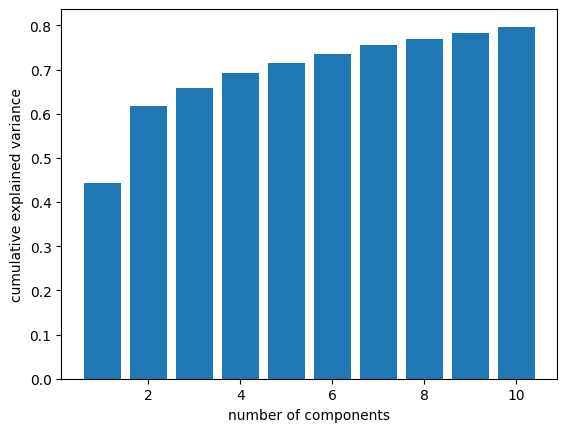

In [14]:
plt.bar(xs, ys)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

With one component, we can capture 44% of the variation in the measurements.
With two components, we're up to 62%.
After that, the gains are smaller (as we expect), but with 10 measurements, we get up to 78%.

## Loadings

Looking at the loadings, we can see which measurements contribute the most to each of the components, so we can get a sense of which characteristics each component captures. 

In [15]:
loadings = pca.components_  # Get the loadings (eigenvectors)

# Create a DataFrame to store the loadings with feature names as columns
loadings_df = pd.DataFrame(loadings, columns=measurements)
loadings_df

,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,...,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight
0,-0.085451,-0.134108,-0.116021,-0.100365,-0.127055,-0.105897,-0.112045,-0.108305,-0.092030,-0.103360,...,-0.124746,-0.094822,-0.097267,-0.095846,-0.087184,-0.082944,-0.114016,-0.131211,-0.115607,-0.120198
1,-0.162882,0.099494,0.106095,-0.092119,0.123047,-0.037801,0.064844,-0.017398,-0.141551,-0.055853,...,-0.096331,-0.038278,-0.157748,-0.165992,-0.161084,-0.061621,0.150431,-0.126668,-0.062109,0.048192
2,-0.014395,-0.122851,0.012478,0.022587,-0.112582,0.073207,0.118888,0.059968,0.103338,-0.135285,...,-0.167957,-0.179743,-0.081042,-0.045141,-0.021002,-0.228053,-0.030050,-0.003647,0.042601,-0.216043
3,0.173882,0.015049,0.085706,-0.166726,0.009381,-0.247001,-0.099352,-0.044522,0.032557,0.021559,...,-0.000876,0.023758,0.131973,0.161462,0.181395,-0.043258,0.010538,0.055891,-0.153309,-0.019576
4,0.067034,0.015734,-0.053763,0.179718,0.008833,0.149046,0.103003,-0.290356,0.026294,0.021543,...,0.014603,0.005616,0.053208,0.058053,0.067614,-0.047541,-0.011571,0.044127,0.064097,0.057868
5,0.068184,0.045087,0.008759,-0.079452,0.034680,-0.068601,-0.007459,-0.210109,-0.059683,0.028774,...,0.014681,0.083141,0.029015,0.049920,0.071052,0.007433,-0.017599,0.003753,-0.105905,0.075342
6,0.093122,0.012056,0.030914,-0.107566,-0.004872,0.023620,0.039973,-0.040000,-0.043709,0.025147,...,0.018115,0.284302,0.026684,0.069259,0.116411,0.204153,-0.124093,-0.022496,0.094696,0.009281
7,-0.051230,0.061714,-0.114750,-0.010113,0.048551,-0.001259,0.086907,-0.009047,0.094866,0.022084,...,-0.008328,0.045395,-0.065001,-0.051299,-0.027950,-0.142685,0.057582,0.006966,0.017728,0.200716
8,-0.003839,-0.041583,0.017699,0.128766,-0.038918,0.076594,0.140068,0.105295,-0.135544,0.259300,...,-0.065624,0.187700,0.110872,0.053250,0.018341,-0.065255,-0.050228,0.005607,-0.100881,-0.054472
9,0.083429,-0.014501,0.065331,-0.043632,-0.003462,-0.107394,0.031256,0.003598,-0.003754,-0.081815,...,0.054063,0.225034,0.018257,0.069098,0.093145,0.271480,-0.128586,0.028110,-0.013300,-0.086483


In [16]:
loadings_transposed = loadings_df.transpose()
loadings_transposed

,0,1,2,3,4,5,6,7,8,9
abdominalextensiondepthsitting,-0.085451,-0.162882,-0.014395,0.173882,0.067034,0.068184,0.093122,-0.051230,-0.003839,0.083429
acromialheight,-0.134108,0.099494,-0.122851,0.015049,0.015734,0.045087,0.012056,0.061714,-0.041583,-0.014501
acromionradialelength,-0.116021,0.106095,0.012478,0.085706,-0.053763,0.008759,0.030914,-0.114750,0.017699,0.065331
anklecircumference,-0.100365,-0.092119,0.022587,-0.166726,0.179718,-0.079452,-0.107566,-0.010113,0.128766,-0.043632
axillaheight,-0.127055,0.123047,-0.112582,0.009381,0.008833,0.034680,-0.004872,0.048551,-0.038918,-0.003462
...,...,...,...,...,...,...,...,...,...,...
waistfrontlengthsitting,-0.082944,-0.061621,-0.228053,-0.043258,-0.047541,0.007433,0.204153,-0.142685,-0.065255,0.271480
waistheightomphalion,-0.114016,0.150431,-0.030050,0.010538,-0.011571,-0.017599,-0.124093,0.057582,-0.050228,-0.128586
weightkg,-0.131211,-0.126668,-0.003647,0.055891,0.044127,0.003753,-0.022496,0.006966,0.005607,0.028110
wristcircumference,-0.115607,-0.062109,0.042601,-0.153309,0.064097,-0.105905,0.094696,0.017728,-0.100881,-0.013300


In [17]:
num_top_features = 5

# Iterate through each principal component
for i, col in loadings_transposed.items():
    print(f"Principal Component {i+1}:")
    
    # Sort the features by absolute loading values for the current principal component
    sorted_features = col.abs().sort_values(ascending=False)
    
    # Select the top N features with the highest absolute loadings
    top_features = sorted_features[:num_top_features]
    
    # Print the top correlated factors for the current principal component
    print(top_features)
    print()

Principal Component 1:
suprasternaleheight    0.135148
cervicaleheight        0.134192
buttockkneelength      0.134150
acromialheight         0.134108
kneeheightsitting      0.133213
Name: 0, dtype: float64

Principal Component 2:
waistcircumference                0.165992
poplitealheight                   0.163478
abdominalextensiondepthsitting    0.162882
waistdepth                        0.161084
buttockdepth                      0.158967
Name: 1, dtype: float64

Principal Component 3:
elbowrestheight            0.337941
eyeheightsitting           0.309933
sittingheight              0.306948
waistfrontlengthsitting    0.228053
heelbreadth                0.225397
Name: 2, dtype: float64

Principal Component 4:
balloffootcircumference    0.247001
bimalleolarbreadth         0.231806
footbreadthhorizontal      0.220106
handbreadth                0.217946
sittingheight              0.212332
Name: 3, dtype: float64

Principal Component 5:
interscyeii              0.320346
biacromialbreadt

I won't explain all of the measurements, but if there are any you are curious about, you can look them up in [*The Measurer’s Handbook*](http://tools.openlab.psu.edu/publicData/ANSURII-TR11-017.pdf) which includes details on "sampling strategy and measuring techniques" as well as descriptions and diagrams of the landmarks and measurements between them.

* Not surprisingly, the first component is loaded with measurements of height. If you want to predict someone's measurements, and can only use one number, choose height.

* The second component is loaded with measurements of girth. Again, no surprises so far.

* The third component seems to capture torso length. And that makes sense, too. One you know how tall someone is, it helps to know how that height is split between torso and legs.

* The fourth component seems to capture hand and foot size (with sitting height thrown in just to remind us that PCA is not obligated to find components that align perfectly with the axes we expect).

* Component 5 is all about the shoulders.

* Component 6 is all about the head.

After that, things are not so neat. But two things are worth noting:

* Component 7 is mostly related to the dimensions of the pelvis, but...

* Components 7, 8, and 10 are surprisingly loaded up with ear measurements.

As we saw in the previous article, there seems to be something special about ears.
Once you have exhausted the information carried by the most obvious measurements, the dimensions of the ear seem to be strangely salient.

Copyright 2023 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).